In [1]:
import numpy as np
from scipy.linalg import solve_discrete_are
from scipy.optimize import minimize
from control.matlab import ss, c2d, dlqr,ss2tf, tf, step
import control 
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import os
from numpy import array
import random
import numpy as geek

import datetime
import math
import gym
from gym import spaces, logger
from gym.utils import seeding

import torch.nn.functional as F
from collections import OrderedDict
from copy import copy
import argparse
from torch.utils.tensorboard import SummaryWriter
import sys
from scipy.integrate import odeint
import time

import scipy
import scipy.linalg
import cvxpy as cp

from scipy.io import savemat

In [26]:
class InvTwoPendulumEnv():
    """
    Description:
    m1 = 2 kg and m2 = 2.5 kg are the pendulum end masses 

    j1 = 0.5 kg and j2 = 0.625 kg are the moments of inertia 

    k = 100 N/m is the spring constant of the connecting spring  

    r = 0.5 m is the pendulum height 

    l = 0.5 m is the natural length of the spring 

    b = 0.4 m  is the distance between the pendulum hinges 

    g = 9.81 m/s2 is the gravitational acceleration.  
    """

    def __init__(self):
        
        self.gravity = 10
        self.m1 = 1
        self.m2 = 1
        self.j1 = 1
        self.j2 = 1
        self.k = 2 #Nm-1
        self.r = 1
        self.l = 0.5
        self.b = 0.4
        
        self.kinematics_integrator = 'euler'
        self.tau = 0.01  # seconds between state updates 0.02
        
        
        # Angle at which to fail the episode
        self.theta_threshold_radians =  24 * 2 * math.pi / 360    #degrees to radian
        
        #theta = 0 is the stable position vertical line, if theta is +(positive) right side
      

        # Angle limit set to 2 * theta_threshold_radians so failing observation is still within bounds
        high = np.array([
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max])

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        theta_coefficient = 1.
        self.reference = (0., 0., 0., 0.)
        
        self.counter = 0
        #self.counter_max = 20000  #200

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        #assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        state = self.state
        self.counter += 1
        theta1, theta_dot1, theta2, theta_dot2 = state
        u1, u2 = action
        
        gravity = self.gravity 
        m1 =self.m1
        m2 = self.m2
        j1 = self.j1
        j2 = self.j2 
        k = self.k
        r = self.r
        l = self.l 
        b = self.b 
        
        

        # Calculate spring force
        #spring_force = -self.spring_stiffness * theta - self.spring_damping * theta_dot


        """
        while theta < -np.pi or theta > np.pi:
            if theta > np.pi:
                theta = theta - 2 * np.pi
            if theta < -np.pi:
                theta = 2 * np.pi + theta
        """
        
        gravity = self.gravity 
        g_div_l =  10 #1
        one_div_ml2 = 1 #1
        mu = 1
        k_div_m = 2
        a_div_l = 0.5
        
        
        #first_term = ((m1 * gravity * r / j1) - (k*(r**2)/4*j1) ) * math.sin(theta1)
        #second_term =  k*r*(l-b)/(2 * j1)
        #third_term = math.tanh(u1)/j1
        #forth_term = k * (r**2 ) * math.sin(theta2) / (4 *j1)
        
        #f_term = ((m2 * gravity * r / j2) - (k*(r**2)/4*j2) ) * math.sin(theta2)
        #s_term =  k*r*(l-b)/(2 * j2)
        #t_term = math.tanh(u2)/j2
        #fo_term = k * (r**2 ) * math.sin(theta1) / (4 *j2)
        
        
        
        #theta_acc1 = first_term + second_term + third_term + forth_term
        #theta_acc2 = f_term -s_term + t_term + fo_term
        
        common_term = k_div_m*a_div_l*a_div_l
        input1 = u1 - (1/3)*u1*u1*u1
        input2 = u2 - (1/3)*u2*u2*u2
        
        theta_acc1 = (g_div_l*math.sin(theta1)) - (common_term * math.sin(theta1)) + (common_term* math.sin(theta2)) + (one_div_ml2*input1) #+ (one_div_ml2*0.5*0.1) 
        theta_acc2 = (g_div_l*math.sin(theta2)) - (common_term * math.sin(theta2)) + (common_term*math.sin(theta1)) + (one_div_ml2*input2) #- (one_div_ml2*0.5*0.1)
        
            
            
        
        if self.kinematics_integrator == 'euler':
            theta1 = theta1 + self.tau * theta_dot1
            theta_dot1 = theta_dot1 + self.tau * theta_acc1
            theta2 = theta2 + self.tau * theta_dot2
            theta_dot2 = theta_dot2 + self.tau * theta_acc2
        

        self.state = (theta1, theta_dot1, theta2, theta_dot2)
        
        #termination
        done = theta1 < -self.theta_threshold_radians \
               or theta1 > self.theta_threshold_radians \
               or theta2 < -self.theta_threshold_radians \
               or theta2 > self.theta_threshold_radians 
               #or self.counter >= self.counter_max
        done = bool(done)
      

        return np.array(self.state), done, {}

    def reset(self, initial_x = 0.0, initial_angle=None, duration=None):
        
        self.state = self.np_random.uniform(low=-0.1, high=0.1, size=(4,)) #0.05
        #self.state[0] = random.uniform(-0.3, 0.3)
        #self.state[1] = random.random()
        #self.state[2] = random.uniform(-0.42, 0.42)
        #self.state[3] = random.random()
        
        
        self.steps_beyond_done = None
        #self.counter = 0
        #self.state = np.array([0.1,0,0.1,0])
        return np.array(self.state)

In [3]:
from scipy.linalg import solve_discrete_are
from scipy.optimize import minimize
from control.matlab import ss, c2d, dlqr
#from control import dlqr

from scipy.signal import ss2zpk, cont2discrete

def gaussian_init_(n_units, std=1):    
    sampler = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([std/n_units]))
    Omega = sampler.sample((n_units, n_units))[..., 0]  
    return Omega

class data_collecter():
    def __init__(self) -> None:
        np.random.seed(2022)
        random.seed(2022)
        
        self.env = InvTwoPendulumEnv()
        self.Nstates = 4 #self.env.Nstates
            
        self.umax = np.array([3]) #self.env.umax
        self.umin = np.array([-3]) #self.env.umin
        self.udim = 2
        
    def collect_koopman_data(self,traj_num,steps,mode="train"):
        train_data = np.empty((steps+1,traj_num,self.Nstates+self.udim))
                
        for traj_i in range(traj_num):
            s0 = self.env.reset()
            u10 = np.random.uniform(self.umin, self.umax, size=(self.udim,))                
            train_data[0,traj_i,:]=np.concatenate([u10.reshape(-1),s0.reshape(-1)],axis=0).reshape(-1)
            
            for i in range(1,steps+1):                   
                s0,done,_ = self.env.step(u10)
                u10 = np.random.uniform(self.umin, self.umax, size=(self.udim,))   
                train_data[i,traj_i,:]=np.concatenate([u10.reshape(-1),s0.reshape(-1)],axis=0).reshape(-1)
        return train_data

In [4]:
class Network(nn.Module):
    def __init__(self,encode_layers,Nkoopman,u_dim):
        super(Network,self).__init__()
        Layers = OrderedDict()
        for layer_i in range(len(encode_layers)-1):
            Layers["linear_{}".format(layer_i)] = nn.Linear(encode_layers[layer_i],encode_layers[layer_i+1])
            if layer_i != len(encode_layers)-2:
                Layers["relu_{}".format(layer_i)] = nn.ReLU()
        self.encode_net = nn.Sequential(Layers)
        self.Nkoopman = Nkoopman
        self.u_dim = u_dim
        self.lA = nn.Linear(Nkoopman,Nkoopman,bias=False)
        self.lA.weight.data = gaussian_init_(Nkoopman, std=1)
        U, _, V = torch.svd(self.lA.weight.data)
        self.lA.weight.data = torch.mm(U, V.t()) * 0.9
        self.lB = nn.Linear(u_dim,Nkoopman,bias=False)

    def encode_only(self,x):
        return self.encode_net(x)

    def encode(self,x):
        return torch.cat([x,self.encode_net(x)],axis=-1)
    
    def forward(self,x,u):
        return self.lA(x)+self.lB(u)

In [5]:
def K_loss(data,net,u_dim=2,Nstate=4):
    steps,train_traj_num,Nstates = data.shape
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = torch.DoubleTensor(data).to(device)
    X_current = net.encode(data[0,:,u_dim:])
    max_loss_list = []
    mean_loss_list = []
    for i in range(steps-1):
        X_current = net.forward(X_current,data[i,:,:u_dim])
        Y = data[i+1,:,u_dim:]
        Err = X_current[:,:Nstate]-Y
        max_loss_list.append(torch.mean(torch.max(torch.abs(Err),axis=0).values).detach().cpu().numpy())
        mean_loss_list.append(torch.mean(torch.mean(torch.abs(Err),axis=0)).detach().cpu().numpy())
    return np.array(max_loss_list),np.array(mean_loss_list)

def Klinear_loss(data,net,mse_loss,u_dim=2,gamma=0.99,Nstate=4,all_loss=0, detach =0):
    steps,train_traj_num,NKoopman = data.shape
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = torch.DoubleTensor(data).to(device)
    X_current = net.encode(data[0,:,u_dim:])  #z
    beta = 1.0
    beta_sum = 0.0
    loss = torch.zeros(1,dtype=torch.float64).to(device)
    Augloss = torch.zeros(1,dtype=torch.float64).to(device)
    uloss = torch.zeros(1,dtype=torch.float64).to(device)
    for i in range(steps-1):
         
        X_current = net.forward(X_current,data[i,:,:u_dim])
        
        beta_sum += beta
        if not all_loss:
            loss += beta*mse_loss(X_current[:,:Nstate],data[i+1,:,u_dim:]) #compare predicted xt+1 with, xt+1 which is with zt+1
        else:
            Y = net.encode(data[i+1,:,u_dim:]) #encode true xt+1 
            loss += beta*mse_loss(X_current,Y)
        X_current_encoded = net.encode(X_current[:,:Nstate]) #encode calculated zt+1
        
        Augloss += mse_loss(X_current_encoded,X_current)
        beta *= gamma
        
        
    #loss = loss/beta_sum
    Augloss = Augloss/beta_sum
    return loss+0.5*Augloss

def Stable_loss(net,Nstate):
    x_ref = np.zeros(Nstate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_ref_lift = net.encode_only(torch.DoubleTensor(x_ref).to(device))
    loss = torch.norm(x_ref_lift)
    return loss

def Eig_loss(net):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    A = net.lA.weight
    c = torch.linalg.eigvals(A).abs()-torch.ones(1,dtype=torch.float64).to(device)
    mask = c>0
    loss = c[mask].sum()
    return loss

In [6]:
def train(all_loss=0,encode_dim = 20,b_dim=2,layer_depth=3,e_loss=1,gamma=0.5,detach = 0, Ktrain_samples=50000):
    # Ktrain_samples = 1000
    # Ktest_samples = 1000
    train_steps = 20000
    Ktrain_samples = Ktrain_samples
    Ktest_samples = 2000
    Ksteps = 15
    Kbatch_size = 1000
    res = 1
    normal = 1
    #data prepare
    data_collect = data_collecter()
    u_dim = data_collect.udim
    Ktest_data = data_collect.collect_koopman_data(Ktest_samples,Ksteps,mode="eval")
    Ktest_samples = Ktest_data.shape[1]
    print("test data ok!,shape:",Ktest_data.shape)
    Ktrain_data = data_collect.collect_koopman_data(Ktrain_samples,Ksteps,mode="train")
    print("train data ok!,shape:",Ktrain_data.shape)
    Ktrain_samples = Ktrain_data.shape[1]
    in_dim = Ktest_data.shape[-1]-u_dim
    Nstate = in_dim
    # layer_depth = 4
    layer_width = 128
    layer_depth_b = 3
    layers = [in_dim]+[layer_width]*layer_depth+[encode_dim]

    Nkoopman = in_dim+encode_dim
    print("layers:",layers)
    net = Network(layers,Nkoopman,u_dim)
    # print(net.named_modules())
    eval_step = 5000
    learning_rate = 1e-3
    if torch.cuda.is_available():
        net.cuda() 
    net.double()
    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(),
                                    lr=learning_rate)
    for name, param in net.named_parameters():
        print("model:",name,param.requires_grad)
    #train
    eval_step = 1000
    best_loss = 1000.0
    best_state_dict = {}
    #logdir = "../Data/"+suffix+"/KoopmanU_"+env_name+"layer{}_edim{}_eloss{}_gamma{}_aloss{}_samples{}".format(layer_depth,encode_dim,e_loss,gamma,all_loss,Ktrain_samples)
    logdir = "logDir_InvPendulum_nonlinear_U_1"
    #------------------------------------------------------

    if not os.path.exists(logdir):
        os.makedirs(logdir)
    writer = SummaryWriter(log_dir=logdir)
    start_time = time.process_time()
    for i in range(train_steps):
        #K loss
        Kindex = list(range(Ktrain_samples))
        random.shuffle(Kindex)
        X = Ktrain_data[:,Kindex[:Kbatch_size],:]
        Kloss = Klinear_loss(X,net,mse_loss,u_dim,gamma,Nstate,all_loss)       
        Eloss = Eig_loss(net)
        loss = Kloss+Eloss if e_loss else Kloss
        
        # loss = Kloss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        writer.add_scalar('Train/Kloss',Kloss,i)
        writer.add_scalar('Train/Eloss',Eloss,i)
        writer.add_scalar('Train/loss',loss,i)
        # print("Step:{} Loss:{}".format(i,loss.detach().cpu().numpy()))
        if (i+1) % eval_step ==0:
            #K loss
            with torch.no_grad():
                Kloss = Klinear_loss(Ktest_data,net,mse_loss,u_dim,gamma,Nstate,all_loss=0, detach =detach)
                Eloss = Eig_loss(net)
                loss = Kloss
                Kloss = Kloss.detach().cpu().numpy()
                Eloss = Eloss.detach().cpu().numpy()
                loss = loss.detach().cpu().numpy()
                writer.add_scalar('Eval/Kloss',Kloss,i)
                writer.add_scalar('Eval/Eloss',Eloss,i)
                writer.add_scalar('Eval/best_loss',best_loss,i)
                writer.add_scalar('Eval/loss',loss,i)
                if loss<best_loss:
                    best_loss = copy(Kloss)
                    best_state_dict = copy(net.state_dict())
                    Saved_dict = {'model':best_state_dict,'layer':layers }
                    torch.save(Saved_dict,logdir+".pth")
                print("Step:{} Eval-loss{} K-loss:{} ".format(i,loss,Kloss))
            # print("-------------END-------------")
        writer.add_scalar('Eval/best_loss',best_loss,i)
        # if (time.process_time()-start_time)>=210*3600:
        #     print("time out!:{}".format(time.clock()-start_time))
        #     break
    print("END-best_loss{}".format(best_loss))
    



In [7]:
#train(all_loss=1,encode_dim=20,b_dim =2,layer_depth=3,e_loss=0,gamma=0.8,detach = 1,Ktrain_samples=50000)

C:\ProgramData\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


test data ok!,shape: (16, 2000, 6)
train data ok!,shape: (16, 50000, 6)
layers: [4, 128, 128, 128, 20]
model: encode_net.linear_0.weight True
model: encode_net.linear_0.bias True
model: encode_net.linear_1.weight True
model: encode_net.linear_1.bias True
model: encode_net.linear_2.weight True
model: encode_net.linear_2.bias True
model: encode_net.linear_3.weight True
model: encode_net.linear_3.bias True
model: lA.weight True
model: lB.weight True
Step:999 Eval-loss[0.07633116] K-loss:[0.07633116] 
Step:1999 Eval-loss[0.0186447] K-loss:[0.0186447] 
Step:2999 Eval-loss[0.01099805] K-loss:[0.01099805] 
Step:3999 Eval-loss[0.00827815] K-loss:[0.00827815] 
Step:4999 Eval-loss[0.00532278] K-loss:[0.00532278] 
Step:5999 Eval-loss[0.00225944] K-loss:[0.00225944] 
Step:6999 Eval-loss[0.0021198] K-loss:[0.0021198] 
Step:7999 Eval-loss[0.00212262] K-loss:[0.00212262] 
Step:8999 Eval-loss[0.00207773] K-loss:[0.00207773] 
Step:9999 Eval-loss[0.00206912] K-loss:[0.00206912] 
Step:10999 Eval-loss[0.0

In [6]:

layer_i=1
Data_collect = data_collecter()
udim = Data_collect.udim
Nstates = Data_collect.Nstates
layer_depth = 3
layer_width = 128
dicts = torch.load("logDir_InvPendulum_nonlinear_U_1.pth")
state_dict = dicts["model"]
layer = dicts["layer"]

NKoopman = layer[-1]+Nstates
net = Network(layer,NKoopman,udim)
net.load_state_dict(state_dict)
device = torch.device("cpu")
# net.cuda()
net.double()

C:\ProgramData\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Network(
  (encode_net): Sequential(
    (linear_0): Linear(in_features=4, out_features=128, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=128, out_features=128, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=128, out_features=20, bias=True)
  )
  (lA): Linear(in_features=24, out_features=24, bias=False)
  (lB): Linear(in_features=2, out_features=24, bias=False)
)

In [7]:
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la

simTime = 3.0
dt = 0.01

# x[k+1] = Ax[k] + Bu[k]
# A = np.matrix([[1, 1.0], [0, 1]])
# B = np.matrix([0.0, 1]).T
# Q = np.matrix([[1.0, 0.0], [0.0, 0.0]])
# R = np.matrix([[1.0]])
Kopt = None


def process(x, u):
    x = A * x + B * u
    return (x)


def solve_DARE_with_iteration(A, B, Q, R):
    """
    solve a discrete time_Algebraic Riccati equation (DARE)
    """
    X = Q
    maxiter = 150
    eps = 0.01

    for i in range(maxiter):
        Xn = A.T * X * A - A.T * X * B * \
            la.inv(R + B.T * X * B) * B.T * X * A + Q
        if (abs(Xn - X)).max() < eps:
            X = Xn
            break
        X = Xn

    return Xn


def dlqr_with_iteration(Ad, Bd, Q, R):
    """Solve the discrete time lqr controller.
    x[k+1] = Ad x[k] + Bd u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    # ref Bertsekas, p.151
    """

    # first, try to solve the ricatti equation
    X = solve_DARE_with_iteration(Ad, Bd, Q, R)

    # compute the LQR gain
    K = np.matrix(la.inv(Bd.T * X * Bd + R) * (Bd.T * X * Ad))

    return K


def dlqr_with_arimoto_potter(Ad, Bd, Q, R):
    """Solve the discrete time lqr controller.
    x[k+1] = Ad x[k] + Bd u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    # ref Bertsekas, p.151
    """

    n = len(Bd)

    # continuous
    Ac = (Ad - np.eye(n)) / dt
    Bc = Bd / dt

    # Hamiltonian
    Ham = np.vstack(
        (np.hstack((Ac, - Bc * la.inv(R) * Bc.T)),
         np.hstack((-Q, -Ac.T))))

    eigVals, eigVecs = la.eig(Ham)

    V1 = None
    V2 = None

    for i in range(2 * n):
        if eigVals[i].real < 0:
            if V1 is None:
                V1 = eigVecs[0:n, i]
                V2 = eigVecs[n:2 * n, i]
            else:
                V1 = np.vstack((V1, eigVecs[0:n, i]))
                V2 = np.vstack((V2, eigVecs[n:2 * n, i]))
    V1 = np.matrix(V1.T)
    V2 = np.matrix(V2.T)

    P = (V2 * la.inv(V1)).real

    K = la.inv(R) * Bc.T * P

    return K

def lqr_abanoub(A,B,Q_matrix,R_matrix):
    R = np.array(R_matrix)   # Cost matrix for control input
    Qq = np.array(Q_matrix)
        
    K11_array = np.array(A) #used to convert the parameters of a PyTorch model layer from a PyTorch tensor to a NumPy array
    K12_array = np.array(B)
        
    # Solve for P
    P = solve_discrete_are(K11_array,K12_array, Qq, R)
        

    # Compute K_LQR
    K_LQR = np.linalg.inv(R + K12_array.T @ P @ K12_array) @ (K12_array.T @ P @ K11_array.T)
        
    
    return K_LQR

def lqr_regulator_k(A,B,Q,R):
    Kopt = dlqr_with_arimoto_potter(A, B, Q, R)
    #Kopt = dlqr_with_iteration(A, B, Q, R) #position is not stabalized
    
    return Kopt
    
def lqr_regulator(x):
    global Kopt
    if Kopt is None:
        start = time.time()
        #  Kopt = dlqr_with_iteration(A, B, np.eye(2), np.eye(1))
        Kopt = dlqr_with_arimoto_potter(A, B, np.eye(4), np.eye(2))

        elapsed_time = time.time() - start
        print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

    u = -Kopt * x
    return u




In [8]:
def Psi_o(s,net): # Evaluates basis functions Ψ(s(t_k))
    psi = np.zeros([NKoopman,1])
    ds = net.encode(torch.DoubleTensor(s)).detach().cpu().numpy()
    psi[:NKoopman,0] = ds
    return psi

def Prepare_LQR(env_name):
    Nstates = 4
    udim = 2
    x_ref = np.zeros(Nstates)
    if env_name.startswith("InvTwoPendulumEnv"):
        #Q = np.zeros((NKoopman,NKoopman))
        Q = np.identity(NKoopman)
        Q[0,0] = 20   
        Q[1,1] = 0.01
        Q[2,2] = 5
        Q[3,3] = 0.01
        R = 0.001*np.eye(udim)
        reset_state=  [0.0,0.0,0.0,0.0]
    
    Q = np.matrix(Q)
    R = np.matrix(R)
    return Q,R,reset_state,x_ref

In [9]:
Ad = state_dict['lA.weight'].cpu().numpy()
Bd = state_dict['lB.weight'].cpu().numpy()
Data_collect = data_collecter()
env = InvTwoPendulumEnv()
Nstates = Data_collect.Nstates
env_name = 'InvTwoPendulumEnv'
env.reset()
#import lqr
rician_factor = 10
M=1

Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)

Kopt = lqr_regulator_k(Ad,Bd,Q,R)
#Kopt = lqr_abanoub(Ad,Bd,Q,R)

observation_list = []
observation = env.reset()

x0 = np.matrix(Psi_o(observation,net))
x_ref_lift = Psi_o(x_ref,net)
observation_list.append(x0[:Nstates].reshape(-1,1))
umax = 1
umin = -1

C:\ProgramData\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


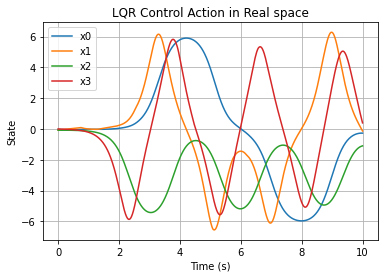

In [27]:
Ad = state_dict['lA.weight'].cpu().numpy()
Bd = state_dict['lB.weight'].cpu().numpy()
Data_collect = data_collecter()
env = InvTwoPendulumEnv()
Nstates = Data_collect.Nstates
env_name = 'InvTwoPendulumEnv'
env.reset()
#import lqr

Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)

Kopt = lqr_regulator_k(Ad,Bd,Q,R)
#Kopt = lqr_abanoub(Ad,Bd,Q,R)

observation_list = []
observation = env.reset()
x0 = np.matrix(Psi_o(observation,net))
x_ref_lift = Psi_o(x_ref,net)
observation_list.append(x0[:Nstates].reshape(-1,1))
umax = 2
umin = -2
#u_latent_max = u_orig_encoder(net, torch.DoubleTensor(np.array([8]).reshape(-1))).detach().numpy()
#u_latent_min = u_orig_encoder(net, torch.DoubleTensor(np.array([-8]).reshape(-1))).detach().numpy()
# print(Kopt)
u_list = []
steps = 1000
# umax = 100
for i in range(steps):
    #print('1')
    # env.render()
    u = -Kopt*(x0-x_ref_lift) #in lifted space
    
    
    
    ureal = u
    #print(ureal)
    
    #print(ureal)
    #ureal1 = ureal[0,0]
    ureal1 = ureal[0,0]
    ureal2 = ureal[1,0]
    
    #print(ureal1)
    #print(ureal2)
    
    #define a range for action
    if(ureal1 > umax):
        ureal1 = umax
    elif(ureal1 < umin):
        ureal1 = umin
        
    if(ureal2 > umax):
        ureal2 = umax
    elif(ureal2 < umin):
        ureal2 = umin
        
    #print(ureal1)
    #print(ureal2)
        
    #gu = net.bilinear_net(torch.DoubleTensor(np.array([ureal1, ureal2]).reshape(-1))).detach().numpy()
    
    #print(ureal1)
    #print(ureal2)
    observation, done, info = env.step([ureal1,ureal2]) #real space
    #print(done)
    x0 = np.matrix(Psi_o(observation,net)) #lifted space
    # x0 = Ad*x0+Bd*u
    #observation_list.append(x0[:Nstates].reshape(-1,1))
    observation_list.append(observation.reshape(-1,1))
    #u_list.append(ureal1)
    # time.sleep(0.1)

observations = np.concatenate(observation_list,axis=1)
#print(observations)
#u_list = np.array(u_list).reshape(-1)
time_history = np.arange(steps+1)*0.01
for i in range(Nstates):
    plt.plot(time_history, observations[i,:].reshape(-1,1), label="x{}".format(i))
    
plt.grid(True)
plt.title("LQR Control Action in Real space")
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend()
plt.show()

In [179]:
observations[:,0]

matrix([[-0.08818709],
        [-0.04803554],
        [-0.01282437],
        [ 0.06287788]])

In [12]:
error_threshold = 0.3
transmit_power = 3.2e-3 #Watt for -15dBm , 3.01dBm = 0.002 W
sense_power = 1e-5 #1 dbm = 0.00102 watt    -20dBm = 100mW
total_battery_power = 1 # 30 dbm = 1 watt total power per hour

intercept = 0.0181
coef = [0, 3.49284851e-01,  4.68731360e-03, -4.54613983e+00,9.55050636e-02, 0]

def calculate_E(state, aoi, intercept, coefficients):
    error = intercept + (coef[1]*state) + (coef[2]*aoi) + (coef[3]*state*state) + (coef[5]*aoi*aoi)+ (coef[4]*state*aoi)            
    return error

In [13]:
def optimal_a(battery_power, p,sense_power, V, Q_a, beta,state, error_threshold, h, h_threshold):
   
    
    a = cp.Variable(nonneg=True)
    gamma = cp.Variable(nonneg=True)
    
    intercept = 0.0181
    coef = [0, 3.49284851e-01,  4.68731360e-03, -4.54613983e+00,9.55050636e-02, 0]

    constant = intercept + (coef[1]*state) + (coef[2]*(1+beta)) + (coef[3]*state*state) + (coef[5]*(1+ (2*beta) + (beta*beta))) + (coef[4]*state*(1+beta))
    c1 = -1 * ((coef[2]*beta) + (2*coef[5]*beta*(1+beta)) + (coef[4]*state*beta)) 
    c2 = coef[5]*beta*beta
    
    # Create constraints.
    constraints = [(constant + (c1*a) + (c2*a**2)) <= error_threshold,
                  battery_power >= a*p + sense_power,
                  a* h >= h_threshold,
                  0 <= a, 
                  a <= 1.0,
                  gamma <= 1.0,
                   0 <= gamma,
                  a <= gamma]
    
    obj = cp.Minimize((V*gamma) + (Q_a* a) - (Q_a* gamma) - (battery_power*(a*p +sense_power )) + (beta*(1-a)))
    
    #p> pmax
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.ECOS, abstol=1e-9, reltol=1e-9)
    
    #print("c2:", c2)
    #print("state:", state)
    #print("beta:", beta)
    #print("battery_power:", battery_power)
    #print("p:", p)
    #print("c1:", c1)
    #print("constant:", constant)
    #print("a:", a.value)
    #print("gamma:", gamma.value)
    #print("Problem status:", prob.status)
    #print('------')
    
    if prob.status == 'infeasible':
        return prob.status, 0, 0
    else:
        return prob.status,a.value, gamma.value

In [14]:
def get_channel_matrix(rician_factor, M):
    
    ang = 2 * np.pi * np.random.rand()

    # Compute phase shift
    phi = -(np.arange(M) * np.pi * np.sin(ang))

    # LOS Component
    h_los = np.sqrt(rician_factor / (1 + rician_factor)) * np.exp(1j * np.pi / 4) * np.exp(1j * phi)
    #h_los = np.sqrt(rician_factor / (1 + rician_factor)) *  np.eye(M)

    # NLOS Component (Rayleigh fading)
    h_nlos = np.sqrt(1 / (2 * (1 + rician_factor))) * (np.random.randn(M) + 1j * np.random.randn(M))
    
    
    #################
    #M*M matrix
    # Phase shift for LOS path
    #phi = -(np.arange(M) * np.pi * np.sin(ang))
    
    # Line-of-Sight (LOS) Component (Rank-1 matrix)
    #h_los = np.sqrt(rician_factor / (1 + rician_factor)) * np.exp(1j * np.pi / 4) * np.exp(1j * phi[:, None])
    #h_los = np.sqrt(rician_factor / (1 + rician_factor))* np.eye(M)

    # Non-Line-of-Sight (NLOS) Component (Rayleigh fading, full MxM)
    #h_nlos = np.sqrt(1 / (2 * (1 + rician_factor))) * (np.random.randn(M, M) + 1j * np.random.randn(M, M))
    
    
    

    # Total channel response
    hf = h_los + h_nlos
    
    return hf

In [46]:
h =get_channel_matrix(10,1)
norm = np.linalg.norm(h)
print(norm*norm)

0.6635653678119304


In [47]:
def cal_snr():
    p = 3.16e-5 #dBm = 0.002 mW
    rician_factor = 10
    M=4
    N0 = -174 #dBm
    bandwidth = 93.8 #dB  = 2.4e+9 Hz
    hf = get_channel_matrix(rician_factor, M)
    snr_threshold = 20 #dbm
    h_norm = np.linalg.norm(hf)
    h_log_value = 10 * np.log(h_norm * h_norm)
    snr = (p + h_log_value) -  (N0 + bandwidth) #dB 
    return snr

In [15]:
def calculate_controls(u_pred_count, net, latent_x, x_ref, Kopt, umax, umin, x_current):
    
    u_dim = 2
    no_of_controls = u_pred_count
    u_array = np.zeros((no_of_controls,u_dim))
    x0 = latent_x
    x_ref_lift = x_ref
     
    
    for i in range(no_of_controls):
        
        u = -Kopt*(x0-x_ref_lift) #in lifted space
        ureal = u
    
        ureal1 = ureal[0,0]
        ureal2 = ureal[1,0]
      
    
    
        #define a range for action
        if(ureal1 > umax):
            ureal1 = umax
        elif(ureal1 < umin):
            ureal1 = umin
        
        if(ureal2 > umax):
            ureal2 = umax
        elif(ureal2 < umin):
            ureal2 = umin
        
        next_state = net.forward(x_current,torch.DoubleTensor(np.array([ureal1, ureal2]).reshape(-1)))    
        #gu = net.bilinear_net(torch.DoubleTensor(np.array([ureal1, ureal2]).reshape(-1)))
        #next_state = net.forward(x_current,gu) 
    
        ac = [ureal1,ureal2]    
        #store u value
        u_array[i,0] = ureal1
        u_array[i,1] = ureal2
        
        x0 = next_state.reshape(-1,1).detach().numpy()
        x_current = next_state.reshape(-1)
        
        
    return u_array   
    

In [30]:
def execute_main(snr, transmit_power, episode, steps, no_control_predictions, h_threshold, error_threshold, Kopt, x_ref, net):
    
    episode = episode
    steps = steps
    snr = snr
    dimension = 4
    latent_dimension = 20
    action_dimention = 2
    starting_states = 1
    prediction_steps = 20
    V = 10
    error_threshold = 0.3
    #h_threshold = 0.12
    h_threshold_dl = 0.12
    rician_factor= 10
    M=1    
    
    transmit_power = transmit_power #Watt for -15dBm , 3.01dBm = 0.002 W
    sense_power = 1e-5 #1 dbm = 0.00102 watt    -20dBm = 100mW
    total_battery_power = 1 #watt
    
    u_pred_count = prediction_steps #Number of control action predictions

    battery_power = np.zeros((episode,steps+1))
    Q_a = np.zeros((episode,steps+1))

    beta = np.zeros((episode,steps+1))
    
    
    env = InvTwoPendulumEnv()
    Nstates = dimension
    env_name = 'InvTwoPendulumEnv'
    env.reset()
    observation = env.reset()

    x0 = np.matrix(Psi_o(observation,net))
    x_ref_lift = Psi_o(x_ref,net)

    umax = 2
    umin = -2

    Q_real = np.identity(dimension)
    Q_real[0,0] = 20     
    Q_real[1,1] = 0.001
    Q_real[2,2] = 5
    Q_real[3,3] = 0.01
    
    R = 0.001*np.eye(action_dimention)

    x_value = np.zeros((episode,steps,dimension))
    x_pred_value = np.zeros((episode,steps,dimension))

    z_value = np.zeros((episode,steps,latent_dimension))
    z_pred_value = np.zeros((episode,steps,latent_dimension))

    x_error = np.zeros((episode,steps,dimension))
    z_error = np.zeros((episode,steps,latent_dimension))

    stability_error = np.zeros((episode,steps))
    control_error = np.zeros((episode,steps))
    total_error = np.zeros((episode,steps))

    u_array = np.zeros((episode,steps,action_dimention))
    

    z_ref = Psi_o(x_ref,net)

    a_array = np.zeros((episode,steps))
    g_array = np.zeros((episode,steps))


    observation = env.reset()
    #observation = exact_start
    x_value[0,0,:] = observation

    x_latent = np.matrix(Psi_o(observation,net))
     
    
    for i in range(episode):
        
        #state = np.array(x_value[0,0,:])                 
        #env.reset_for_given_state(state)
        state = env.reset()
        x_value[i,0,:] = state
    
        observation = state
    
    
        x0 = np.matrix(Psi_o(observation,net))    
        x_current = net.encode(torch.DoubleTensor(observation))
    
        beta[i,0] = 1
    
        required_power = sense_power + transmit_power
        battery_power[i,0] = total_battery_power
        Q_a[i,0] = 1
      
        counter = 0
    
        last_send_state = state
        
        succ_ca = ((u_pred_count,action_dimention))
        ca_counter = 0 #count not received packets in ca link
            
        for j in range(steps):
        
            
            counter = counter +1
            #call control action computation method
            predicted_array = calculate_controls(u_pred_count, net, x0, x_ref_lift, Kopt, umax, umin, x_current)
        
            ureal1 = predicted_array[0,0]
            ureal2 = predicted_array[0,1]
            
            #gu = net.bilinear_net(torch.DoubleTensor(np.array([ureal1, ureal2]).reshape(-1)))
            #next_state = net.forward(x_current,gu) 
            next_state = net.forward(x_current,torch.DoubleTensor(np.array([ureal1, ureal2]).reshape(-1)))
        
            if j == 0:
                succ_ca = predicted_array
            else:
                h =get_channel_matrix(rician_factor,M)
                norm = np.linalg.norm(h)
                h_square = norm*norm
                
                if h_square >= h_threshold_dl: #successfully transmit
                    succ_ca = predicted_array
                    ca_counter = 0
                else:
                    ca_counter = 1 + ca_counter
                    
                    if ca_counter > (prediction_steps-1):
                        ca_counter = prediction_steps -1
                    
            control_action1 = succ_ca[ca_counter, 0]
            control_action2 = succ_ca[ca_counter, 1]
            
            ac = [control_action1,control_action2]
            u_array[i,j,:] = ac
            
            observation, done, info = env.step(ac) #real space    
            x_value[i,j,:] = observation 
        
            #real z value for store
            z_store = np.matrix(Psi_o(observation,net)) #lifted space
            z_value[i,j,:] = z_store[Nstates:].reshape(-1)
        
            #solve minimization problem
            state_norm = np.linalg.norm(last_send_state)
            error = calculate_E(state_norm, beta[i,j], intercept, coef)
        
            h =get_channel_matrix(rician_factor,M)
            norm = np.linalg.norm(h)
            h_square = norm*norm
        
            if battery_power[i,j] < (transmit_power+sense_power):
                print('battery power over')
                a = 0
                g = 0
                beta[i,j+1] = 1+beta[i, j]
                x0 = next_state.reshape(-1,1).detach().numpy()
                x_current = next_state.reshape(-1)
            
                if (battery_power[i,j] - sense_power) < 0 :
                    battery_power[i,j] = 0
                else:
                    battery_power[i,j+1] = battery_power[i,j] - sense_power
                
                a_array[i,j] = a
                g_array[i,j] = g
                
            elif h_square < h_threshold:
                a = 0
                g = 0
            
                a_array[i,j] = a
                g_array[i,j] = g
            
                battery_power[i,j+1] = battery_power[i,j] - sense_power
                beta[i,j+1] = 1+beta[i, j]
                x0 = next_state.reshape(-1,1).detach().numpy()
                x_current = next_state.reshape(-1)
            
            else:
            
                feasible,a,g = optimal_a(battery_power[i,j], transmit_power,sense_power, V, Q_a[i,j], beta[i,j], state_norm, error_threshold, h_square, h_threshold)       
        
                #get value for a #due to error threshold
                if feasible == 'infeasible':
                    print('Infeasible point occured')
                    a = 1
                    gamma = 1
                
                    a_array[i,j] = a
                    g_array[i,j] = g
                else:
                    a = round(float(a), 3)            
                    g = round(float(g), 3)
                
                    a_array[i,j] = a
                    g_array[i,j] = g
        
                if a >= 0.5:           #transmission occur
                    beta[i,j+1] = 1
                    x0 = np.matrix(Psi_o(observation,net)) #lifted space
                    x_current = net.encode(torch.DoubleTensor(observation))
                    battery_power[i,j+1] = battery_power[i,j] - required_power
                
                    last_send_state = observation
                       
            
                else:
                    beta[i,j+1] = 1+beta[i, j]
                    x0 = next_state.reshape(-1,1).detach().numpy()
                    x_current = next_state.reshape(-1)
                    battery_power[i,j+1] = battery_power[i,j] - sense_power
            
            
            
            #e_value = calculate_E(state_norm, beta[i,j+1], intercept, coef)
            Q_a[i,j+1] = np.max(Q_a[i,j]- g_array[i,j], 0) + a_array[i,j]
            
            x_pred_value[i,j,:] = x0[:Nstates].reshape(-1) ##########################
            z_pred_value[i,j,:] = x0[Nstates:].reshape(-1) ############################
                        
        
            #stability error
            #difference =  next_state.reshape(-1,1).detach().numpy() - z_ref  #z-z0
            #stability_d = difference.T * Q * difference
            #stability_error[i,j] = stability_d
        
            difference =  observation  #z-z0
            stability_d = np.dot(np.dot(observation, Q_real), observation)
            stability_error[i,j] = stability_d
            
            u_cost = np.dot(np.dot(ac, R), ac)
            control_error[i,j] = u_cost
            total_error[i,j] = stability_d + u_cost
                                         
    #save data
    mdic = {"x_val": x_value, "z_val": z_value,"x_pred_value":x_pred_value,"z_pred_value":z_pred_value, 'stability_error': stability_error, 'u_array':u_array, 'control_error':control_error,'total_error':total_error, 'Q_a':Q_a, 'a':a_array, 'g':g_array, 'bat_power':battery_power, 'beta':beta }
    savemat(f"matlab_U_outage{h_threshold}_SNR{snr}_epi{episode}_V{V}.mat", mdic)
    print(h_threshold)
    
    #time_history = np.arange(steps)*0.01
    ##for i in range(Nstates):
    #plt.plot(time_history, total_error[0,:].reshape(-1,1), label="x{}".format(i))
    
    #plt.grid(True)
    #plt.title("LQR Control Action in Real space")
    #plt.xlabel('Time (s)')
    #plt.ylabel('State')
    #plt.legend()
    #plt.show()
    

In [53]:
#outage values 1e-4, 1e-3 , 1e-2, 1e-1, 1, 10
s_values = [0.045, 0.12, 0.25, 0.51] 

In [31]:
#calculate for different snr
#sensor_power = 1e-5 #1 dbm = 0.00102 watt    -20dBm = 100mW 
episode = 100
steps = 1000
no_control_predictions = 10 
h_threshold = 0.12 
error_threshold = 0.3 
Nw = 3.8e-8

for snr in range(25,26,5):
    
    snr_linear = 10 ** (snr / 10)    #in watt
    p = snr_linear * Nw / h_threshold   #in watt
    transmit_power = p
    
    execute_main(snr, transmit_power, episode, steps, no_control_predictions, h_threshold, error_threshold, Kopt, x_ref, net)

C:\ProgramData\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


0.12


In [54]:
#calculate for different outage
episode = 100
steps = 1000
no_control_predictions = 10 
h_threshold = 0.12 
error_threshold = 0.3 
Nw = 3.8e-8
snr = 20

for h_val in s_values:
    
    snr_linear = 10 ** (snr / 10)    #in watt
    p = snr_linear * Nw / h_val   #in watt
    transmit_power = p
    
    execute_main(snr, transmit_power, episode, steps, no_control_predictions, h_val, error_threshold, Kopt, x_ref, net)

C:\ProgramData\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


0.045


C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0.12
0.25
0.51


In [18]:
#stability test
episode = 1
steps = 1000
dimension = 4
latent_dimension = 20
action_dimention = 2
starting_states = 1
prediction_steps = 10
V = 20
error_threshold = 0.3
h_threshold = 0.12

battery_power = np.zeros((episode,steps+1))
Q_a = np.zeros((episode,steps+1))

beta = np.zeros((episode,steps+1))

Q_real = np.identity(dimension)
Q_real[0,0] = 2000     
Q_real[1,1] = 0.001
Q_real[2,2] = 500
Q_real[3,3] = 0.01

x_value = np.zeros((episode,steps,dimension))
x_pred_value = np.zeros((episode,steps,dimension))

z_value = np.zeros((episode,steps,latent_dimension))
z_pred_value = np.zeros((episode,steps,latent_dimension))

x_error = np.zeros((episode,steps,dimension))
z_error = np.zeros((episode,steps,latent_dimension))

stability_error = np.zeros((episode,steps))

u1_array = np.zeros((episode,steps))
u2_array = np.zeros((episode,steps))

z_ref = Psi_o(x_ref,net)

a_array = np.zeros((episode,steps))
g_array = np.zeros((episode,steps))


observation = env.reset()
#observation = exact_start
x_value[0,0,:] = observation

x_latent = np.matrix(Psi_o(observation,net))
     
    
for i in range(episode):
        
    #state = np.array(x_value[0,0,:])                 
    #env.reset_for_given_state(state)
    state = env.reset()
    x_value[i,0,:] = state
    
    observation = state
    
    
    x0 = np.matrix(Psi_o(observation,net))    
    x_current = net.encode(torch.DoubleTensor(observation))
    
    beta[i,0] = 1
    
    required_power = sense_power + transmit_power
    battery_power[i,0] = total_battery_power
    Q_a[i,0] = 1
      
    counter = 0
    
    last_send_state = state
            
    for j in range(steps):
        
            
        counter = counter +1
        
        
        u = -Kopt*(x0-x_ref_lift) #in lifted space
      
        ureal = net.bilinear_decode_net(torch.DoubleTensor(u.reshape(-1))).detach().numpy()
        #print(ureal)
    
        #print(ureal)
        #ureal1 = ureal[0,0]
        ureal1 = ureal[0,0]
        ureal2 = ureal[0,1]
    
    
    
        #define a range for action
        if(ureal1 > umax):
            ureal1 = umax
        elif(ureal1 < umin):
            ureal1 = umin
        
        if(ureal2 > umax):
            ureal2 = umax
        elif(ureal2 < umin):
            ureal2 = umin
        
    
        
        gu = net.bilinear_net(torch.DoubleTensor(np.array([ureal1, ureal2]).reshape(-1)))
        next_state = net.forward(x_current,gu) 
    
        ac = [ureal1,ureal2]
    
        observation, done, info = env.step(ac) #real space    
        x_value[i,j,:] = observation 
        
        #real z value for store
        z_store = np.matrix(Psi_o(observation,net)) #lifted space
        z_value[i,j,:] = z_store[Nstates:].reshape(-1)
        
        #solve minimization problem
        state_norm = np.linalg.norm(last_send_state)
        error = calculate_E(state_norm, beta[i,j], intercept, coef)
        
        h =get_channel_matrix(rician_factor,M)
        norm = np.linalg.norm(h)
        h_square = norm*norm
        
        if battery_power[i,j] < (transmit_power+sense_power):
            print('battery power over')
            a = 0
            g = 0
            beta[i,j+1] = 1+beta[i, j]
            x0 = next_state.reshape(-1,1).detach().numpy()
            x_current = next_state.reshape(-1)
            
            if (battery_power[i,j] - sense_power) < 0 :
                battery_power[i,j] = 0
            else:
                battery_power[i,j+1] = battery_power[i,j] - sense_power
                
            a_array[i,j] = a
            g_array[i,j] = g
                
        elif h_square < h_threshold:
            a = 0
            g = 0
            
            a_array[i,j] = a
            g_array[i,j] = g
            
            battery_power[i,j+1] = battery_power[i,j] - sense_power
            beta[i,j+1] = 1+beta[i, j]
            x0 = next_state.reshape(-1,1).detach().numpy()
            x_current = next_state.reshape(-1)
            
        else:
            
            feasible,a,g = optimal_a(battery_power[i,j], transmit_power,sense_power, V, Q_a[i,j], beta[i,j], state_norm, error_threshold, h_square, h_threshold)       
        
            #get value for a #due to error threshold
            if feasible == 'infeasible':
                print('Infeasible point occured')
                a = 1
                gamma = 1
                
                a_array[i,j] = a
                g_array[i,j] = g
            else:
                a = round(float(a), 3)            
                g = round(float(g), 3)
                
                a_array[i,j] = a
                g_array[i,j] = g
        
            if a >= 0.5:           #transmission occur
                beta[i,j+1] = 1
                x0 = np.matrix(Psi_o(observation,net)) #lifted space
                x_current = net.encode(torch.DoubleTensor(observation))
                battery_power[i,j+1] = battery_power[i,j] - required_power
                
                last_send_state = observation
                       
            
            else:
                beta[i,j+1] = 1+beta[i, j]
                x0 = next_state.reshape(-1,1).detach().numpy()
                x_current = next_state.reshape(-1)
                battery_power[i,j+1] = battery_power[i,j] - sense_power
            
            
            
        #e_value = calculate_E(state_norm, beta[i,j+1], intercept, coef)
        Q_a[i,j+1] = np.max(Q_a[i,j]- g_array[i,j], 0) + a_array[i,j]
            
        x_pred_value[i,j,:] = x0[:Nstates].reshape(-1) ##########################
        z_pred_value[i,j,:] = x0[Nstates:].reshape(-1) ############################
                        
        
        #stability error
        #difference =  next_state.reshape(-1,1).detach().numpy() - z_ref  #z-z0
        #stability_d = difference.T * Q * difference
        #stability_error[i,j] = stability_d
        
        difference =  observation  #z-z0
        stability_d = np.dot(np.dot(observation, Q_real), observation)
        stability_error[i,j] = stability_d
        
        
                                  
        observation_list.append(observation.reshape(-1,1))
        u1_array[i,j]= ureal1
        u2_array[i,j]= ureal2
            
        #update Q_e() Q_e[i,j] + Error - threshold
        #update beta

In [96]:
Q_a[0,:]

array([1., 1., 1., ..., 1., 1., 1.])

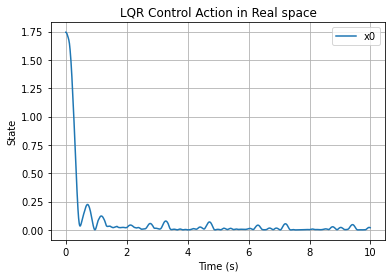

In [19]:
time_history = np.arange(steps)*0.01
#for i in range(Nstates):
plt.plot(time_history, stability_error[0,:].reshape(-1,1), label="x{}".format(i))
    
plt.grid(True)
plt.title("LQR Control Action in Real space")
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend()
plt.show()

In [98]:
from scipy.io import savemat


snr = 40

mdic = {"x_val": x_value, "z_val": z_value,"x_pred_value":x_pred_value,"z_pred_value":z_pred_value, 'stability_error': stability_error, 'u1_array':u1_array, 'u2_array':u2_array, 'Q_a':Q_a, 'a':a_array, 'g':g_array, 'bat_power':battery_power, 'beta':beta }
savemat(f"matlab_stability_cost_proposed_V{V}_SNR{snr}_pred.mat", mdic)

In [148]:
np.max(beta[0,:])

20.0

In [163]:
#test constraint feasibility
V_val = 100
V_sum = 10


episode = 1
steps = 1000
dimension = 4
latent_dimension = 20
action_dimention = 2
starting_states = 1
prediction_steps = 10


Q_real = np.identity(dimension)
Q_real[0,0] = 2000     
Q_real[1,1] = 0.001
Q_real[2,2] = 500
Q_real[3,3] = 0.01

feasibility_checker = 0

for l in range(1): 
    delta_val = 0.5
    delta_sum = 0.1
    
    for m in range(50):
        
        #stability test


        battery_power = np.zeros((episode,steps+1))
        Q_a = np.zeros((episode,steps+1))

        beta = np.zeros((episode,steps+1))



        x_value = np.zeros((episode,steps,dimension))
        x_pred_value = np.zeros((episode,steps,dimension))

        z_value = np.zeros((episode,steps,latent_dimension))
        z_pred_value = np.zeros((episode,steps,latent_dimension))

        x_error = np.zeros((episode,steps,dimension))
        z_error = np.zeros((episode,steps,latent_dimension))

        stability_error = np.zeros((episode,steps))

        u1_array = np.zeros((episode,steps))
        u2_array = np.zeros((episode,steps))

        z_ref = Psi_o(x_ref,net)


        observation = env.reset()
        #observation = exact_start
        x_value[0,0,:] = observation

        x_latent = np.matrix(Psi_o(observation,net))
            
        
        for i in range(episode):
        
            #state = np.array(x_value[0,0,:])                 
            #env.reset_for_given_state(state)
            state = env.reset()
            x_value[i,0,:] = state
    
            observation = state
    
    
            x0 = np.matrix(Psi_o(observation,net))    
            x_current = net.encode(torch.DoubleTensor(observation))
        
            beta[i,0] = 1
    
            required_power = sense_power + transmit_power
            battery_power[i,0] = total_battery_power
            Q_a[i,0] = 1
      
            counter = 0
            
            for j in range(steps):
        
            
                counter = counter +1
        
        
                u = -Kopt*(x0-x_ref_lift) #in lifted space
      
                ureal = net.bilinear_decode_net(torch.DoubleTensor(u.reshape(-1))).detach().numpy()
        
                ureal1 = ureal[0,0]
                ureal2 = ureal[0,1]
    
    
    
                #define a range for action
                if(ureal1 > umax):
                    ureal1 = umax
                elif(ureal1 < umin):
                    ureal1 = umin
        
                if(ureal2 > umax):
                    ureal2 = umax
                elif(ureal2 < umin):
                    ureal2 = umin
        
    
        
                gu = net.bilinear_net(torch.DoubleTensor(np.array([ureal1, ureal2]).reshape(-1)))
                next_state = net.forward(x_current,gu) 
    
                ac = [ureal1,ureal2]
    
                observation, done, info = env.step(ac) #real space    
                x_value[i,j,:] = observation 
        
                #real z value for store
                z_store = np.matrix(Psi_o(observation,net)) #lifted space
                z_value[i,j,:] = z_store[Nstates:].reshape(-1)
        
                #solve minimization problem
                state_norm = np.linalg.norm(observation)
                error = calculate_E(state_norm, beta[i,j], intercept, coef)
        
                if battery_power[i,j] < (transmit_power+sense_power):
                    print('battery power over')
                    a = 0
                    beta[i,j+1] = 1+beta[i, j]
                    x0 = next_state.reshape(-1,1).detach().numpy()
                    x_current = next_state.reshape(-1)
            
                    if (battery_power[i,j] - sense_power) < 0 :
                        battery_power[i,j] = 0
                    else:
                        battery_power[i,j+1] = battery_power[i,j] - sense_power
            
                else:
                    feasible,a,g = optimal_a(battery_power[i,j], transmit_power,sense_power, V_val, Q_a[i,j], beta[i,j], state_norm, delta_val)       
        
                    #get value for a 
                    if feasible == 'infeasible':
                        with open("optimal_point_V100.txt", "a") as file:
                            file.write("!!!!!Break Loop -  infeasible.!!!!!\n")
                            file.write(f"V value: {V_val}\n")
                            file.write(f"Delta: {delta_val}\n")
                            file.write(f"Max beta: {np.max(beta[0,:])}\n")
                            file.write(f"stability: {stability_error[i,j]}\n")
                        
                        break
                        
                    else:
                        a = round(float(a), 3)            
                        g = round(float(g), 3)
        
                    if a >= 0.5:
                        beta[i,j+1] = 1
                        x0 = np.matrix(Psi_o(observation,net)) #lifted space
                        x_current = net.encode(torch.DoubleTensor(observation))
                        battery_power[i,j+1] = battery_power[i,j] - required_power
                       
            
                    else:
                        beta[i,j+1] = 1+beta[i, j]
                        x0 = next_state.reshape(-1,1).detach().numpy()
                        x_current = next_state.reshape(-1)
                        battery_power[i,j+1] = battery_power[i,j] - sense_power
            
            
            
                #e_value = calculate_E(state_norm, beta[i,j+1], intercept, coef)
                Q_a[i,j+1] = np.max(Q_a[i,j]- g, 0) + a
            
                x_pred_value[i,j,:] = x0[:Nstates].reshape(-1) ##########################
                z_pred_value[i,j,:] = x0[Nstates:].reshape(-1) ############################
                        
        
        
                #stability
                difference =  observation  #z-z0
                stability_d = np.dot(np.dot(observation, Q_real), observation)
                stability_error[i,j] = stability_d
        
        
                                  
                observation_list.append(observation.reshape(-1,1))
                u1_array[i,j]= ureal1
                u2_array[i,j]= ureal2
        


            #writing to a file
            with open("optimal_point_V100.txt", "a") as file:
                file.write("------New Test.......\n")
                #file.write(f"V value: {V_val}\n")
                file.write(f"Delta: {delta_val}\n")
                file.write(f"Max beta: {np.max(beta[0,:])}\n")
                file.write(f"stability: {stability_error[i,j]}\n")
            
        
        #delta_val = delta_val + delta_sum
        
    #V_val = V_val + V_sum

C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [65]:
battery_power[i,999]

0.7580100000000453

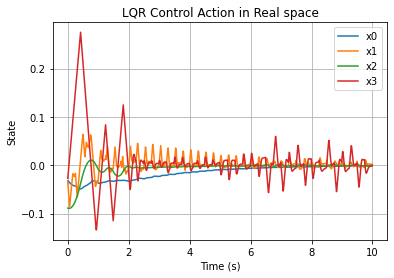

In [161]:
time_history = np.arange(steps)*0.01
for i in range(Nstates):
    plt.plot(time_history, x_value[0,:,i].reshape(-1,1), label="x{}".format(i))
    
plt.grid(True)
plt.title("LQR Control Action in Real space")
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend()
plt.show()

In [25]:
a = cp.Variable()

# Define constraints
constraints = [0 <= a, a <= 1]

# Define an objective function (for example, maximize a)
objective = cp.Maximize(a)

# Form and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Print the optimal value of a
print("Optimal value of a:", a.value)

Optimal value of a: 0.9999999962150865


C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
